### 얼굴 검출 (Dlib 라이브러리 활용)
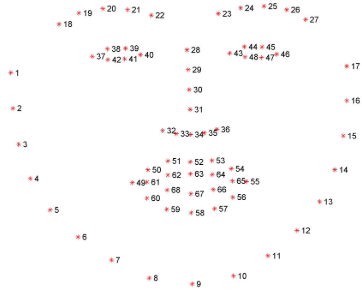
- 얼굴의 68개의 랜드마크 검출
- !pip install cmake 설치해줘야함
- !pip install dlib
- !pip install imutils (OpenCV가 제공하는 기능중 복잡하고 사용성이 떨어지는 부분 보완)

In [1]:
import dlib
print("Dlib 설치 테스트: ", dlib.__version__)

Dlib 설치 테스트:  19.24.6


In [2]:
import cv2
import imutils
import numpy as np
from imutils import face_utils
import matplotlib.pyplot as plt

In [3]:
# dlib 얼굴 추출기 생성
detector = dlib.get_frontal_face_detector() 

# 얼굴 랜드마크 예측기 생성 (shape_predictor_68_face_landmarks.dat 는 68개 랜드마크 찾아주는 모델)
predictor = dlib.shape_predictor('./images/shape_predictor_68_face_landmarks.dat')

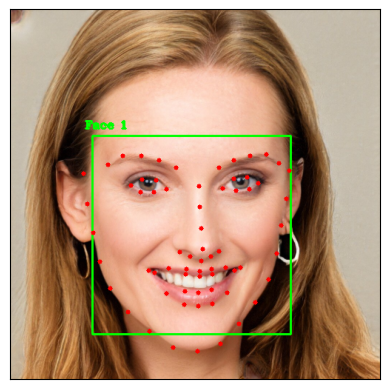

In [4]:
# 얼굴 이미지 불러오기
img = cv2.imread('images/face.jpg', cv2.IMREAD_COLOR)
# 이미지 크기 변경
img = imutils.resize(img, width=500)
# 흑백 이미지 변경
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 얼굴 영역 및 랜드마크 추출
rects = detector(gray, 1)

for (i, rect) in enumerate(rects):
    # 얼굴 영역의 랜드마크 찾고
    shape = predictor(gray, rect)
    # 랜드마크 좌표를 배열로 변환 (np)
    shape = face_utils.shape_to_np(shape)

    # 사각형을 그려줌 (이게 얼굴이야~) 사각형의 좌상단 좌표(x,y)와 너비 높이, 얼굴을 검출하는 바운딩 박스
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # 얼굴 인덱스 표시
    cv2.putText(img, "Face {}".format(i + 1), (x-10, y-10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,255,0), 2)

    # 랜드마크 점 표시
    for(x, y) in shape:
        cv2.circle(img, (x, y), 3, (0, 0, 255), -1)


# 우리는 cv2 쓸거니까 BRG로 써여함 RGB는 확인하려고 컨버트한거임
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.xticks([]), plt.yticks([])
plt.imshow(img)

### 얼굴에 스티커 붙이기

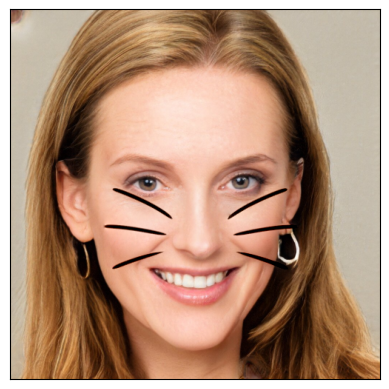

In [5]:
# 추출기랑 예측기 가져오기
detector = dlib.get_frontal_face_detector() # 얼굴 검출
predictor = dlib.shape_predictor('./images/shape_predictor_68_face_landmarks.dat') #얼굴 랜드마크 추출

# 얼굴 이미지 정보 가져오기
img = cv2.imread('images/face.jpg', cv2.IMREAD_COLOR)
img = imutils.resize(img, width=500)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

rects = detector(gray, 1) # 얼굴 검출 정보

# 스티커 이미지
sticker = cv2.imread('./images/sticker.png')
sticker = cv2.cvtColor(sticker, cv2.COLOR_BGR2RGB)

# enumerate 는 rects 정보를 순서 (인덱스 번호)를 붙여서 반환해줌
for (i, rect) in enumerate(rects):
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    (x, y, w, h) = face_utils.rect_to_bb(rect) # 얼굴 검출 위치! (좌표)

    # 스티커 이미지의 크기를 얼굴 영역에 맞춰 변경
    sticker = cv2.resize(sticker, (w, h//2))
    # 스티커 이미지를 흰색 마스크로 생성
    mask = 255 * np.ones(sticker.shape, sticker.dtype)
    # 스티커의 중앙 좌표를 29번 랜드마크로 설정
    center = shape[29]    
    # 스티커 이미지를 얼굴 이미지에 붙이기
    img = cv2.seamlessClone(sticker, img, mask, center, cv2.MIXED_CLONE)



# 출력
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.xticks([]), plt.yticks([])
plt.imshow(img)

### 영상에 스티커 붙이기

In [6]:
# 스티커 붙이는 함수
def Sticker_attach(img_org, img_sticker, detector_hog, landmark_predictor):
    img_rgb = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)

    # 얼굴 영역 검출
    dlib_rects = detector_hog(img_rgb, 0)
    # 얼굴영역이 검출되지 않는다면 전체 이미지 반환
    if len(dlib_rects) < 1 :
        return img_org
    # 랜드마크 검출
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map (lambda p: (p.x, p.y), points.parts())) # lamda -> 간단한함수를 한줄로 만드는거
        list_landmarks.append(list_points)
    # 스티커 위치 좌표 설정을 위한 랜드마크 좌표
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        w = dlib_rect.width()
        h = dlib_rect.height()
        # 코 랜드마크의 x좌표 가져오기
        x = landmark[30][0]
        y = landmark[30][1]
        break

    # 스티커 이미지 크기를 얼굴 영역의 크기로 변환
    img_sticker = cv2.resize(img_sticker, (w, h), interpolation=cv2.INTER_LINEAR)

    # 스티커 시작점의 x좌표
    x = x-w //2
    y = y-h - h//2

    if y < 0: # y가 0보다 작으면 화면을 벗어나는 경우임
        img_sticker = img_sticker[-y:] # 스티커를 벗어난 크기만큼 자름
        y = 0

    img_bgr = img_org.copy()
    # 원본 이미지에서 스티커의 ROI 설정( 관심 영역 )
    sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]

    # 원본 이미지와 스티커 ROI에 스티커 이미지를 합한 이미지를 배치
    img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = cv2.addWeighted(sticker_area, 1.0, img_sticker, 0.9, 0) # 0.9 = 투명도
    
    return img_bgr


#### 얼굴에 각도에 따라 기울어지는 기능까지 추가 해보자

In [7]:
import math

# 스티커를 얼굴 각도에 맞게 회전후 붙이는 함수
def Sticker_attach_rotate(img_org, img_sticker, detector_hog, landmark_predictor):
    img_rgb = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)

    # 얼굴 영역 검출
    dlib_rects = detector_hog(img_rgb, 0)
    # 얼굴영역이 검출되지 않는다면 전체 이미지 반환
    if len(dlib_rects) < 1 :
        return img_org
    # 랜드마크 검출
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map (lambda p: (p.x, p.y), points.parts())) # lamda -> 간단한함수를 한줄로 만드는거
        list_landmarks.append(list_points)
    # 스티커 위치 좌표 설정을 위한 랜드마크 좌표
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        w = dlib_rect.width()
        h = dlib_rect.height()
        # 코 랜드마크의 x좌표 가져오기
        x = landmark[30][0]
        y = landmark[30][1]

        # 얼굴 회전 각도를 구하기 위한 좌표 가져오기 (28, 31 코양끝)
        x1 = landmark[31][0]
        y1 = landmark[31][1]
        x2 = landmark[28][0]
        y2 = landmark[28][1]

        break

    # 스티커 이미지 크기를 얼굴 영역의 크기로 변환
    img_sticker = cv2.resize(img_sticker, (w, h), interpolation=cv2.INTER_LINEAR)

    # 스티커 이미지 회전각
    angle = 360 - math.degrees(math.atan2(x1 - x2, y1 - y2))
    # 회전을 위한 행렬 생성 (중심좌표, 각도, 크기)
    matrix = cv2.getRotationMatrix2D( (img_sticker.shape[0]/2, img_sticker.shape[1]/2), angle, 1 )

    # 어파인 변환
    img_sticker = cv2.warpAffine(img_sticker, matrix, (int(w+w*0.2), int(h+h*0.02)))

    # 스티커 시작점의 x좌표
    x = x-w //2
    y = y-h - h//2

    if y < 0: # y가 0보다 작으면 화면을 벗어나는 경우임
        img_sticker = img_sticker[-y:] # 스티커를 벗어난 크기만큼 자름
        y = 0

    img_bgr = img_org.copy()
    # 원본 이미지에서 스티커의 ROI 설정( 관심 영역 )
    sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]

    # 원본 이미지와 스티커 ROI에 스티커 이미지를 합한 이미지를 배치
    img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = cv2.addWeighted(sticker_area, 1.0, img_sticker, 0.9, 0) # 0.9 = 투명도
    
    return img_bgr


In [8]:
# 영상 출력
cap = cv2.VideoCapture('images/video_for_sticker.mp4')
img_sticker = cv2.imread('./images/crown.png')
# 얼굴 정보
detector = dlib.get_frontal_face_detector() # 얼굴 검출
predictor = dlib.shape_predictor('./images/shape_predictor_68_face_landmarks.dat') #얼굴 랜드마크 추출

while cap.isOpened():
    ret, frame = cap.read() # 동영상의 한 프레임 읽기

    if not ret:
        print("이미지 읽기 실패 혹은 전체 영상 플레이 완료")
        break

    # 스티커 부착 함수
    img_result = Sticker_attach_rotate(frame, img_sticker.copy(), detector, predictor)

    cv2.imshow("video", img_result)

    key = cv2.waitKey(1) # 숫자가 적어지면 프레임이 훅지나감

    # 영상 재생 종료 기능 (키보드 누르면)
    if key == 49:  # 숫자 1
        break

cap.release()
cv2.destroyAllWindows()


In [9]:
# lambda 매개변수 : 표현식(return)
# def hap(x, y):
#     return x + y
# hap(3, 20) -> 이거를 람다식으로 표현하면
# lambda식
(lambda x, y : x+y)(3, 20)

23

In [10]:
# zip 함수
과일 = ['딸기', '메론', '블루베리']
print(과일)
과자 = [ '포카칩', '스윙칩', '허니버터칩']
print(과자)
print('-' * 30)
for i in zip(과일, 과자):
    print(i)

['딸기', '메론', '블루베리']
['포카칩', '스윙칩', '허니버터칩']
------------------------------
('딸기', '포카칩')
('메론', '스윙칩')
('블루베리', '허니버터칩')
